Chosen index: 9558
XY shape: (305, 2)
First xy: [186. 146.]


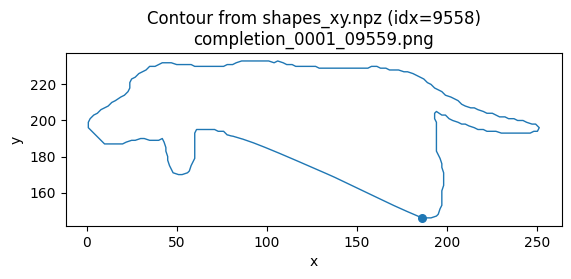

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# --- inputs you can change ---
npz_path = "/home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_1/generated/shapes_xy.npz"
best_png = "/home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_1/generated/completions/completion_0001_09559.png"

# --- load ---
data = np.load(npz_path, allow_pickle=True)
polygons = data["polygons"]
out_files = np.array([str(x) for x in data["out_files"]], dtype=object)
matlab_1_indexed = bool(data["matlab_1_indexed"])

# --- parse best_png ---
best_base = os.path.basename(best_png)
m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
if not m:
    raise ValueError(f"Could not parse best_png filename: {best_base}")

completion_idx_str, shape_id_str = m.group(1), m.group(2)
shape_id_int = int(shape_id_str)

# --- find polygon index ---
# 1) exact basename match
matches = [i for i, s in enumerate(out_files) if os.path.basename(s) == best_base]

# 2) substring match
if not matches:
    matches = [i for i, s in enumerate(out_files) if best_base in s]

# 3) shape-id match (last resort)
if not matches:
    matches = [i for i, s in enumerate(out_files) if (shape_id_str in s) or (str(shape_id_int) in s)]

# 4) direct indexing guess
chosen_idx = None
if matches:
    chosen_idx = matches[0]
else:
    idx = shape_id_int - 1 if matlab_1_indexed else shape_id_int
    if 0 <= idx < len(polygons):
        chosen_idx = idx

if chosen_idx is None:
    raise RuntimeError("Could not locate the polygon for best_png via out_files or direct indexing.")

xy = np.asarray(polygons[chosen_idx], dtype=float)

print("Chosen index:", chosen_idx)
print("XY shape:", xy.shape)
print("First xy:", xy[0])
if matches and len(matches) > 1:
    print("Note: multiple matches found. Using the first one. n_matches =", len(matches))

# --- plot ---
plt.figure()
plt.plot(xy[:, 0], xy[:, 1], linewidth=1)
plt.scatter([xy[0, 0]], [xy[0, 1]], s=30)  # start point marker
plt.gca().set_aspect("equal", adjustable="box")
plt.title(f"Contour from shapes_xy.npz (idx={chosen_idx})\n{best_base}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [1]:
import json
import re
from datetime import datetime

# --- inputs ---
jsonl_path = "/home/hschatzle/monte-carlo-selection/results/certainty_metrics.jsonl"  # adjust if needed
prefix = "elephant_7_val_"  # target series

# --- load + filter ---
pat = re.compile(rf"^{re.escape(prefix)}(\d+)$")

by_case = {}  # case_id -> record (latest by timestamp)

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line_no, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        rec = json.loads(line)
        
        case_id = rec.get("case_id", "")
        m = pat.match(case_id)
        if not m:
            continue
        
        ts = rec.get("timestamp_utc")
        if ts is None:
            # if no timestamp, keep first occurrence unless replaced later with timestamped one
            ts_key = None
        else:
            # parse ISO-8601 with timezone; replace 'Z' if present
            ts_key = datetime.fromisoformat(ts.replace("Z", "+00:00"))
        
        prev = by_case.get(case_id)
        if prev is None:
            by_case[case_id] = rec
        else:
            prev_ts = prev.get("timestamp_utc")
            prev_ts_key = datetime.fromisoformat(prev_ts.replace("Z", "+00:00")) if prev_ts else None
            
            # keep the latest timestamp if both exist. if only one exists, prefer the one with a timestamp
            if prev_ts_key is None and ts_key is not None:
                by_case[case_id] = rec
            elif prev_ts_key is not None and ts_key is not None and ts_key > prev_ts_key:
                by_case[case_id] = rec
            elif prev_ts_key is None and ts_key is None:
                # both missing timestamp. keep the later line as a tie-breaker
                by_case[case_id] = rec

# --- sort by numeric suffix ---
def suffix_num(cid: str) -> int:
    m = pat.match(cid)
    return int(m.group(1)) if m else 10**9

selected = sorted(
    [(cid, r.get("best_png"), r.get("timestamp_utc")) for cid, r in by_case.items()],
    key=lambda t: suffix_num(t[0])
)

print(f"Matched cases with prefix '{prefix}':", len(selected))
if selected:
    print("First 5:")
    for row in selected[:5]:
        print(" ", row)
    print("Last 5:")
    for row in selected[-5:]:
        print(" ", row)

# handy outputs
case_ids = [cid for cid, _, _ in selected]
best_pngs = [p for _, p, _ in selected]


Matched cases with prefix 'elephant_7_val_': 15
First 5:
  ('elephant_7_val_1', '/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_1/generated/completions/completion_0001_06673.png', '2026-02-05T12:03:35+00:00')
  ('elephant_7_val_2', '/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_2/generated/completions/completion_0001_03881.png', '2026-02-05T12:05:41+00:00')
  ('elephant_7_val_3', '/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_3/generated/completions/completion_0001_01436.png', '2026-02-05T12:07:48+00:00')
  ('elephant_7_val_4', '/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_4/generated/completions/completion_0001_05537.png', '2026-02-05T12:09:57+00:00')
  ('elephant_7_val_5', '/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_5/generated/completions/completion_0001_06524.png', '2026-02-05T12:12:02+00:00')
Last 5:
  ('elephant_7_val_11', '/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_1

Loaded contours: 15
Failures: 0

Min points: ('elephant_7_val_1', 373)
Max points: ('elephant_7_val_15', 373)


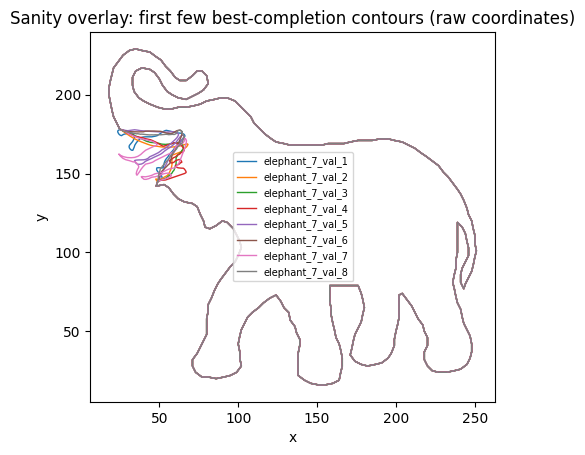

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have: selected = [(case_id, best_png, timestamp_utc), ...]
# Example: created by your previous cell

# Root where your cases live
CASES_ROOT = "/home/hschatzle/monte-carlo-selection/data/cases"

def get_xy_for_best_png(case_id: str, best_png: str) -> np.ndarray:
    """Load shapes_xy.npz for this case and return the polygon matching best_png."""
    npz_path = os.path.join(CASES_ROOT, case_id, "generated", "shapes_xy.npz")
    data = np.load(npz_path, allow_pickle=True)
    polygons = data["polygons"]
    out_files = np.array([str(x) for x in data["out_files"]], dtype=object)
    matlab_1_indexed = bool(data["matlab_1_indexed"])

    best_base = os.path.basename(best_png)

    # Strategy 1: exact basename match
    matches = [i for i, s in enumerate(out_files) if os.path.basename(s) == best_base]

    # Strategy 2: substring match
    if not matches:
        matches = [i for i, s in enumerate(out_files) if best_base in s]

    # Strategy 3: try matching by shape id embedded in filename
    if not matches:
        m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
        if m:
            shape_id_str = m.group(2)
            shape_id_int = int(shape_id_str)
            matches = [i for i, s in enumerate(out_files) if (shape_id_str in s) or (str(shape_id_int) in s)]

    # Strategy 4: direct indexing guess if nothing matches
    chosen_idx = None
    if matches:
        chosen_idx = matches[0]
    else:
        m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
        if m:
            shape_id_int = int(m.group(2))
            idx = shape_id_int - 1 if matlab_1_indexed else shape_id_int
            if 0 <= idx < len(polygons):
                chosen_idx = idx

    if chosen_idx is None:
        raise RuntimeError(f"Could not find polygon for case_id={case_id} best_png={best_png}")

    xy = np.asarray(polygons[chosen_idx], dtype=float)
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError(f"Polygon has unexpected shape {xy.shape} for case_id={case_id}")

    return xy

# --- build dict of curves ---
xy_by_case = {}
failures = []

for case_id, best_png, ts in selected:
    try:
        xy_by_case[case_id] = get_xy_for_best_png(case_id, best_png)
    except Exception as e:
        failures.append((case_id, str(e)))

print("Loaded contours:", len(xy_by_case))
print("Failures:", len(failures))
if failures:
    print("First 5 failures:")
    for row in failures[:5]:
        print(" ", row)

# --- quick summary ---
lengths = [(cid, xy.shape[0]) for cid, xy in xy_by_case.items()]
lengths_sorted = sorted(lengths, key=lambda t: t[1])
if lengths_sorted:
    print("\nMin points:", lengths_sorted[0])
    print("Max points:", lengths_sorted[-1])

# --- sanity plot: overlay a handful ---
plt.figure()
for i, (cid, xy) in enumerate(list(xy_by_case.items())[:8]):
    plt.plot(xy[:, 0], xy[:, 1], linewidth=1, label=cid)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Sanity overlay: first few best-completion contours (raw coordinates)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=7)
plt.show()


Done.
Distance matrices shapes: (15, 15) (15, 15) (15, 15) (15, 15)


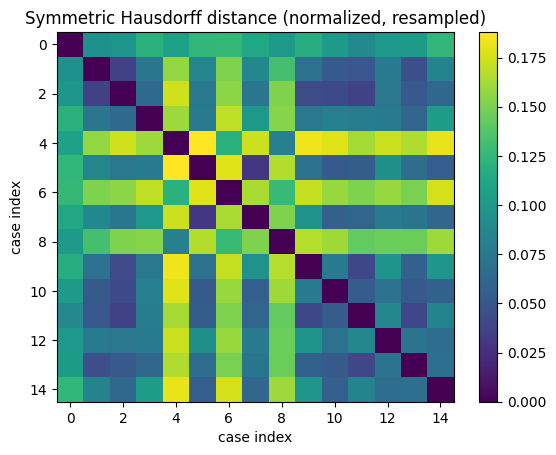

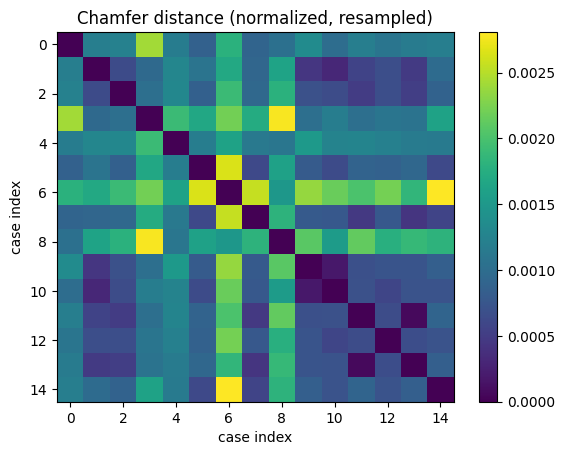

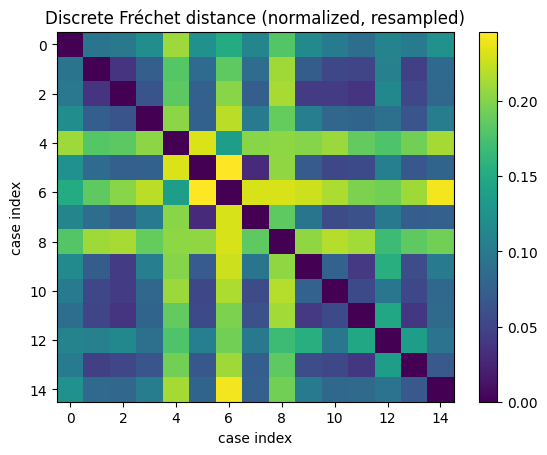

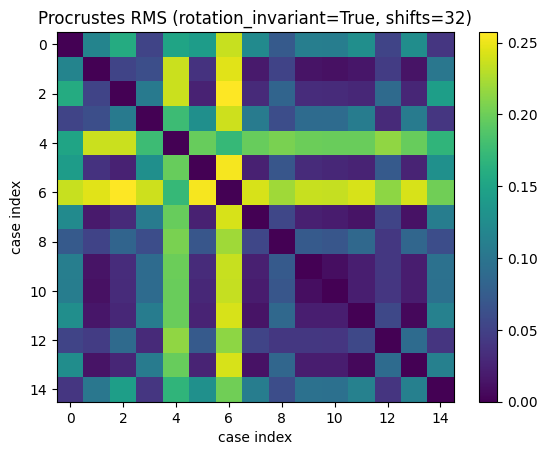


Top-3 neighbors by RMS (per case):
elephant_7_val_1 -> [('elephant_7_val_15', 0.040847841915869425), ('elephant_7_val_13', 0.05276859797709385), ('elephant_7_val_4', 0.05284370249057517)]
elephant_7_val_2 -> [('elephant_7_val_11', 0.011552156661005807), ('elephant_7_val_10', 0.013752617175678003), ('elephant_7_val_14', 0.013912088379688207)]
elephant_7_val_3 -> [('elephant_7_val_6', 0.024288225676038055), ('elephant_7_val_14', 0.027577045922160322), ('elephant_7_val_12', 0.028253337065394353)]
elephant_7_val_4 -> [('elephant_7_val_13', 0.031084672140996892), ('elephant_7_val_15', 0.040747073811767884), ('elephant_7_val_1', 0.05284370249057517)]
elephant_7_val_5 -> [('elephant_7_val_1', 0.15023449497659064), ('elephant_7_val_15', 0.16852350481200787), ('elephant_7_val_7', 0.17261577248235585)]
elephant_7_val_6 -> [('elephant_7_val_8', 0.023864520212457132), ('elephant_7_val_3', 0.024288225676038055), ('elephant_7_val_12', 0.025313231818153453)]
elephant_7_val_7 -> [('elephant_7_val_5',

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Settings you can tweak
# ----------------------------
N_RESAMPLE = 256          # points per contour after resampling
ROTATION_INVARIANT = True # Procrustes alignment in RMS metric
ALLOW_REFLECTION = False  # if True, mirrored shapes can match in RMS metric
CYCLIC_SHIFTS = 32        # how many cyclic shifts to try for RMS (higher = better, slower)
EPS = 1e-12

case_ids = list(xy_by_case.keys())

# ----------------------------
# Helpers: normalize + resample
# ----------------------------
def center_and_scale(xy: np.ndarray) -> np.ndarray:
    xy = np.asarray(xy, float)
    xy = xy - xy.mean(axis=0, keepdims=True)
    # scale by RMS radius
    r = np.sqrt((xy**2).sum(axis=1)).mean()
    r = max(r, EPS)
    return xy / r

def resample_closed_curve_uniform_arclength(xy: np.ndarray, n: int) -> np.ndarray:
    """Resample a closed polygonal curve to n points uniformly along arc length."""
    xy = np.asarray(xy, float)
    if len(xy) < 3:
        raise ValueError("Contour too short")

    # ensure closed
    if not np.allclose(xy[0], xy[-1]):
        xy = np.vstack([xy, xy[0]])

    seg = np.diff(xy, axis=0)
    seglen = np.sqrt((seg**2).sum(axis=1))
    cum = np.concatenate([[0.0], np.cumsum(seglen)])
    total = cum[-1]
    if total < EPS:
        raise ValueError("Degenerate contour (zero perimeter)")

    # target arc-length positions
    t = np.linspace(0.0, total, n+1)[:-1]  # n points, omit endpoint
    # interpolate x and y separately
    x = np.interp(t, cum, xy[:, 0])
    y = np.interp(t, cum, xy[:, 1])
    return np.column_stack([x, y])

# ----------------------------
# Distance metrics
# ----------------------------
def pairwise_sq_dists(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Return matrix of squared distances between points in A and B."""
    # (m,1,2) - (1,n,2) -> (m,n,2) -> (m,n)
    D = A[:, None, :] - B[None, :, :]
    return (D * D).sum(axis=2)

def hausdorff_symmetric(A: np.ndarray, B: np.ndarray) -> float:
    D2 = pairwise_sq_dists(A, B)
    h_ab = np.sqrt(D2.min(axis=1).max())
    h_ba = np.sqrt(D2.min(axis=0).max())
    return max(h_ab, h_ba)

def chamfer(A: np.ndarray, B: np.ndarray) -> float:
    D2 = pairwise_sq_dists(A, B)
    # mean of nearest-neighbor squared distances, symmetric
    return float(D2.min(axis=1).mean() + D2.min(axis=0).mean())

def discrete_frechet(P: np.ndarray, Q: np.ndarray) -> float:
    """Discrete Fréchet distance for ordered curves (O(n^2))."""
    n, m = len(P), len(Q)
    # distance matrix
    D = np.sqrt(pairwise_sq_dists(P, Q))
    ca = np.full((n, m), -1.0)

    def c(i, j):
        if ca[i, j] > -0.5:
            return ca[i, j]
        if i == 0 and j == 0:
            ca[i, j] = D[0, 0]
        elif i > 0 and j == 0:
            ca[i, j] = max(c(i-1, 0), D[i, 0])
        elif i == 0 and j > 0:
            ca[i, j] = max(c(0, j-1), D[0, j])
        else:
            ca[i, j] = max(min(c(i-1, j), c(i-1, j-1), c(i, j-1)), D[i, j])
        return ca[i, j]

    return float(c(n-1, m-1))

def procrustes_rms(A: np.ndarray, B: np.ndarray, rotation: bool, reflect: bool) -> float:
    """RMS after optional optimal rotation (and optional reflection). Assumes pointwise correspondence."""
    A = np.asarray(A, float)
    B = np.asarray(B, float)

    # center
    A0 = A - A.mean(axis=0, keepdims=True)
    B0 = B - B.mean(axis=0, keepdims=True)

    if not rotation:
        diff = A0 - B0
        return float(np.sqrt((diff*diff).sum(axis=1).mean()))

    # Orthogonal Procrustes via SVD
    M = B0.T @ A0
    U, S, Vt = np.linalg.svd(M)
    R = U @ Vt

    # enforce no-reflection if desired
    if not reflect and np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    B_aligned = B0 @ R
    diff = A0 - B_aligned
    return float(np.sqrt((diff*diff).sum(axis=1).mean()))

def cyclic_shifted_rms(A: np.ndarray, B: np.ndarray, n_shifts: int, rotation: bool, reflect: bool) -> float:
    """Try a set of cyclic shifts of B to reduce sensitivity to start index. Returns the minimum RMS."""
    n = len(B)
    if n_shifts <= 1:
        return procrustes_rms(A, B, rotation=rotation, reflect=reflect)

    # sample shifts evenly
    shifts = np.linspace(0, n-1, n_shifts, dtype=int)
    best = np.inf
    for s in shifts:
        B_shift = np.roll(B, shift=s, axis=0)
        d = procrustes_rms(A, B_shift, rotation=rotation, reflect=reflect)
        if d < best:
            best = d
    return float(best)

# ----------------------------
# Build normalized, resampled curves
# ----------------------------
curves = {}
for cid in case_ids:
    xy = xy_by_case[cid]
    xy = center_and_scale(xy)
    xy = resample_closed_curve_uniform_arclength(xy, N_RESAMPLE)
    curves[cid] = xy

# ----------------------------
# Compute pairwise distance matrices
# ----------------------------
n = len(case_ids)
D_haus = np.zeros((n, n), float)
D_cham = np.zeros((n, n), float)
D_fre  = np.zeros((n, n), float)
D_rms  = np.zeros((n, n), float)

for i in range(n):
    A = curves[case_ids[i]]
    for j in range(i, n):
        B = curves[case_ids[j]]

        dh = hausdorff_symmetric(A, B)
        dc = chamfer(A, B)
        df = discrete_frechet(A, B)
        dr = cyclic_shifted_rms(A, B, n_shifts=CYCLIC_SHIFTS,
                               rotation=ROTATION_INVARIANT, reflect=ALLOW_REFLECTION)

        D_haus[i, j] = D_haus[j, i] = dh
        D_cham[i, j] = D_cham[j, i] = dc
        D_fre[i, j]  = D_fre[j, i]  = df
        D_rms[i, j]  = D_rms[j, i]  = dr

print("Done.")
print("Distance matrices shapes:", D_haus.shape, D_cham.shape, D_fre.shape, D_rms.shape)

# ----------------------------
# Quick visualization: heatmaps
# ----------------------------
def show_heatmap(D, title):
    plt.figure()
    plt.imshow(D, aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("case index")
    plt.ylabel("case index")
    plt.show()

show_heatmap(D_haus, "Symmetric Hausdorff distance (normalized, resampled)")
show_heatmap(D_cham, "Chamfer distance (normalized, resampled)")
show_heatmap(D_fre, "Discrete Fréchet distance (normalized, resampled)")
show_heatmap(D_rms, f"Procrustes RMS (rotation_invariant={ROTATION_INVARIANT}, shifts={CYCLIC_SHIFTS})")

# ----------------------------
# Optional: nearest neighbors per case (top 3)
# ----------------------------
def top_k_neighbors(D, k=3):
    out = {}
    for i, cid in enumerate(case_ids):
        idx = np.argsort(D[i])
        idx = [j for j in idx if j != i][:k]
        out[cid] = [(case_ids[j], float(D[i, j])) for j in idx]
    return out

nn_rms = top_k_neighbors(D_rms, k=3)
print("\nTop-3 neighbors by RMS (per case):")
for cid in case_ids[:10]:
    print(cid, "->", nn_rms[cid])


Best indices found for cases: 15
Random curves loaded: 300
Within-case best–random distances computed: 300
Across-case best–best distances computed: 105
Across-case random–random distances computed: 105


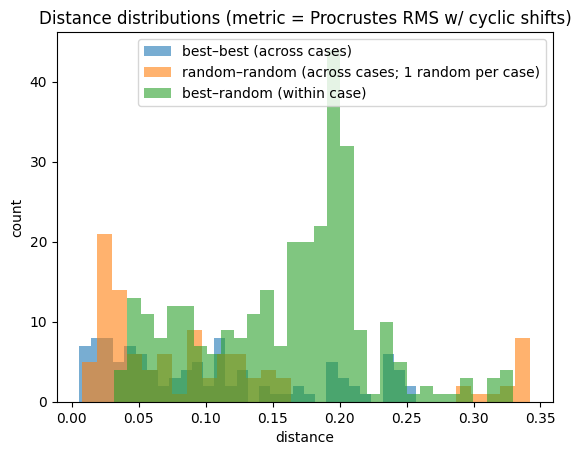


Per-case best–random summary (mean, median, min). Showing 10 smallest mean distances:
  ('elephant_7_val_3', 0.10659215436023213, 0.1051985715213117, 0.03147861782370374)
  ('elephant_7_val_8', 0.10852522169265451, 0.12078991843704168, 0.04312717925508351)
  ('elephant_7_val_12', 0.13133030241323101, 0.15482662898307492, 0.039023027531138316)
  ('elephant_7_val_11', 0.13195171838806366, 0.14295018278906751, 0.03985425238374427)
  ('elephant_7_val_6', 0.13458963281885425, 0.14347137680634547, 0.07088754196689122)
  ('elephant_7_val_14', 0.1372980742870943, 0.1410400715258806, 0.05582296180941401)
  ('elephant_7_val_9', 0.1424215915802766, 0.16597094805080026, 0.043813523370237306)
  ('elephant_7_val_2', 0.15574943998067134, 0.18218024322924903, 0.03211807590280318)
  ('elephant_7_val_10', 0.16354808560879056, 0.16867835206064646, 0.08794027422012177)
  ('elephant_7_val_13', 0.1685551311533749, 0.1927865116495992, 0.05855796143465132)

Showing 10 largest mean distances:
  ('elephant_7_v

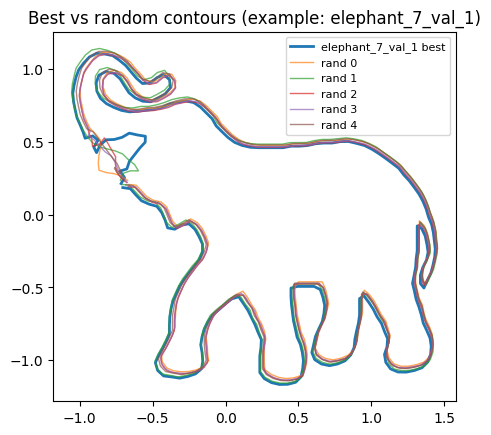

In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Settings
# ----------------------------
N_RESAMPLE = 256
RANDOM_PER_CASE = 20      # how many random completions per case
SEED = 123
ROTATION_INVARIANT = True
ALLOW_REFLECTION = False
CYCLIC_SHIFTS = 32
EPS = 1e-12

CASES_ROOT = "/home/hschatzle/monte-carlo-selection/data/cases"

# Assumes you already have:
#   selected = [(case_id, best_png, timestamp_utc), ...]
#   xy_by_case = {case_id: xy_best, ...}   (best curves already extracted)
case_ids = [cid for cid, _, _ in selected if cid in xy_by_case]

# ----------------------------
# Helpers: normalize + resample
# ----------------------------
def center_and_scale(xy: np.ndarray) -> np.ndarray:
    xy = np.asarray(xy, float)
    xy = xy - xy.mean(axis=0, keepdims=True)
    r = np.sqrt((xy**2).sum(axis=1)).mean()
    r = max(r, EPS)
    return xy / r

def resample_closed_curve_uniform_arclength(xy: np.ndarray, n: int) -> np.ndarray:
    xy = np.asarray(xy, float)
    if len(xy) < 3:
        raise ValueError("Contour too short")

    if not np.allclose(xy[0], xy[-1]):
        xy = np.vstack([xy, xy[0]])

    seg = np.diff(xy, axis=0)
    seglen = np.sqrt((seg**2).sum(axis=1))
    cum = np.concatenate([[0.0], np.cumsum(seglen)])
    total = cum[-1]
    if total < EPS:
        raise ValueError("Degenerate contour")

    t = np.linspace(0.0, total, n+1)[:-1]
    x = np.interp(t, cum, xy[:, 0])
    y = np.interp(t, cum, xy[:, 1])
    return np.column_stack([x, y])

# ----------------------------
# Distance helpers (RMS with cyclic shifts + Procrustes)
# ----------------------------
def pairwise_sq_dists(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    D = A[:, None, :] - B[None, :, :]
    return (D * D).sum(axis=2)

def hausdorff_symmetric(A: np.ndarray, B: np.ndarray) -> float:
    D2 = pairwise_sq_dists(A, B)
    h_ab = np.sqrt(D2.min(axis=1).max())
    h_ba = np.sqrt(D2.min(axis=0).max())
    return float(max(h_ab, h_ba))

def chamfer(A: np.ndarray, B: np.ndarray) -> float:
    D2 = pairwise_sq_dists(A, B)
    return float(D2.min(axis=1).mean() + D2.min(axis=0).mean())

def discrete_frechet(P: np.ndarray, Q: np.ndarray) -> float:
    n, m = len(P), len(Q)
    D = np.sqrt(pairwise_sq_dists(P, Q))
    ca = np.full((n, m), -1.0)

    def c(i, j):
        if ca[i, j] > -0.5:
            return ca[i, j]
        if i == 0 and j == 0:
            ca[i, j] = D[0, 0]
        elif i > 0 and j == 0:
            ca[i, j] = max(c(i-1, 0), D[i, 0])
        elif i == 0 and j > 0:
            ca[i, j] = max(c(0, j-1), D[0, j])
        else:
            ca[i, j] = max(min(c(i-1, j), c(i-1, j-1), c(i, j-1)), D[i, j])
        return ca[i, j]

    return float(c(n-1, m-1))

def procrustes_rms(A: np.ndarray, B: np.ndarray, rotation: bool, reflect: bool) -> float:
    A0 = A - A.mean(axis=0, keepdims=True)
    B0 = B - B.mean(axis=0, keepdims=True)

    if not rotation:
        diff = A0 - B0
        return float(np.sqrt((diff*diff).sum(axis=1).mean()))

    M = B0.T @ A0
    U, _, Vt = np.linalg.svd(M)
    R = U @ Vt
    if not reflect and np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    B_aligned = B0 @ R
    diff = A0 - B_aligned
    return float(np.sqrt((diff*diff).sum(axis=1).mean()))

def cyclic_shifted_rms(A: np.ndarray, B: np.ndarray, n_shifts: int, rotation: bool, reflect: bool) -> float:
    n = len(B)
    if n_shifts <= 1:
        return procrustes_rms(A, B, rotation=rotation, reflect=reflect)
    shifts = np.linspace(0, n-1, n_shifts, dtype=int)
    best = np.inf
    for s in shifts:
        d = procrustes_rms(A, np.roll(B, shift=s, axis=0), rotation=rotation, reflect=reflect)
        if d < best:
            best = d
    return float(best)

# Pick one metric to compare distributions quickly (you can add others below)
def dist_metric(A, B):
    return cyclic_shifted_rms(A, B, n_shifts=CYCLIC_SHIFTS, rotation=ROTATION_INVARIANT, reflect=ALLOW_REFLECTION)

# ----------------------------
# Identify best index inside shapes_xy.npz for each case (so random sampling can exclude it)
# ----------------------------
def find_best_polygon_index(case_id: str, best_png: str) -> int:
    npz_path = os.path.join(CASES_ROOT, case_id, "generated", "shapes_xy.npz")
    data = np.load(npz_path, allow_pickle=True)
    out_files = np.array([str(x) for x in data["out_files"]], dtype=object)
    polygons = data["polygons"]
    matlab_1_indexed = bool(data["matlab_1_indexed"])

    best_base = os.path.basename(best_png)

    matches = [i for i, s in enumerate(out_files) if os.path.basename(s) == best_base]
    if not matches:
        matches = [i for i, s in enumerate(out_files) if best_base in s]

    if not matches:
        m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
        if m:
            shape_id_str = m.group(2)
            shape_id_int = int(shape_id_str)
            matches = [i for i, s in enumerate(out_files) if (shape_id_str in s) or (str(shape_id_int) in s)]

    if matches:
        return matches[0]

    # direct indexing guess
    m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
    if m:
        shape_id_int = int(m.group(2))
        idx = shape_id_int - 1 if matlab_1_indexed else shape_id_int
        if 0 <= idx < len(polygons):
            return idx

    raise RuntimeError(f"Could not locate best index for case_id={case_id}")

# map case_id -> best_png from selected
best_png_by_case = {cid: best_png for cid, best_png, _ in selected if cid in xy_by_case}

best_idx_by_case = {}
for cid in case_ids:
    best_idx_by_case[cid] = find_best_polygon_index(cid, best_png_by_case[cid])

print("Best indices found for cases:", len(best_idx_by_case))

# ----------------------------
# Sample random completions per case (excluding best)
# ----------------------------
rng = np.random.default_rng(SEED)

random_curves = {}  # key: (case_id, r) -> resampled curve
best_curves = {}    # key: case_id -> resampled curve

for cid in case_ids:
    # prepare best curve
    best_xy = resample_closed_curve_uniform_arclength(center_and_scale(xy_by_case[cid]), N_RESAMPLE)
    best_curves[cid] = best_xy

    # load polygons for random sampling
    npz_path = os.path.join(CASES_ROOT, cid, "generated", "shapes_xy.npz")
    data = np.load(npz_path, allow_pickle=True)
    polygons = data["polygons"]

    n_total = len(polygons)
    best_i = best_idx_by_case[cid]

    # candidate indices excluding best
    candidates = np.arange(n_total)
    candidates = candidates[candidates != best_i]

    # sample without replacement (or with replacement if RANDOM_PER_CASE > available)
    if RANDOM_PER_CASE <= len(candidates):
        picks = rng.choice(candidates, size=RANDOM_PER_CASE, replace=False)
    else:
        picks = rng.choice(candidates, size=RANDOM_PER_CASE, replace=True)

    for r_i, idx in enumerate(picks):
        xy = np.asarray(polygons[idx], float)
        xy = resample_closed_curve_uniform_arclength(center_and_scale(xy), N_RESAMPLE)
        random_curves[(cid, r_i)] = xy

print("Random curves loaded:", len(random_curves))

# ----------------------------
# Compare: best–random within-case distances
# ----------------------------
best_random_dists = []  # all distances
best_random_by_case = {}  # cid -> list

for cid in case_ids:
    A = best_curves[cid]
    ds = []
    for r_i in range(RANDOM_PER_CASE):
        B = random_curves[(cid, r_i)]
        d = dist_metric(A, B)
        ds.append(d)
        best_random_dists.append(d)
    best_random_by_case[cid] = ds

print("Within-case best–random distances computed:", len(best_random_dists))

# ----------------------------
# Compare: best–best across cases (upper triangle)
# ----------------------------
best_best_dists = []
for i in range(len(case_ids)):
    for j in range(i+1, len(case_ids)):
        d = dist_metric(best_curves[case_ids[i]], best_curves[case_ids[j]])
        best_best_dists.append(d)

print("Across-case best–best distances computed:", len(best_best_dists))

# ----------------------------
# Compare: random–random across cases
# We'll sample one random per case to match the "best set size" (fair comparison).
# ----------------------------
random_one_per_case = {cid: random_curves[(cid, 0)] for cid in case_ids}

rand_rand_dists = []
for i in range(len(case_ids)):
    for j in range(i+1, len(case_ids)):
        d = dist_metric(random_one_per_case[case_ids[i]], random_one_per_case[case_ids[j]])
        rand_rand_dists.append(d)

print("Across-case random–random distances computed:", len(rand_rand_dists))

# ----------------------------
# Plots: distribution comparison
# ----------------------------
plt.figure()
plt.hist(best_best_dists, bins=30, alpha=0.6, label="best–best (across cases)")
plt.hist(rand_rand_dists, bins=30, alpha=0.6, label="random–random (across cases; 1 random per case)")
plt.hist(best_random_dists, bins=30, alpha=0.6, label="best–random (within case)")
plt.title("Distance distributions (metric = Procrustes RMS w/ cyclic shifts)")
plt.xlabel("distance")
plt.ylabel("count")
plt.legend()
plt.show()

# ----------------------------
# Quick per-case summary: is best unusually close to randoms?
# ----------------------------
means = [(cid, float(np.mean(ds)), float(np.median(ds)), float(np.min(ds))) for cid, ds in best_random_by_case.items()]
means_sorted = sorted(means, key=lambda t: t[1])

print("\nPer-case best–random summary (mean, median, min). Showing 10 smallest mean distances:")
for row in means_sorted[:10]:
    print(" ", row)

print("\nShowing 10 largest mean distances:")
for row in means_sorted[-10:]:
    print(" ", row)

# ----------------------------
# Optional: overlay best + a few randoms for one example case
# ----------------------------
example_cid = case_ids[0]
plt.figure()
plt.plot(best_curves[example_cid][:,0], best_curves[example_cid][:,1], linewidth=2, label=f"{example_cid} best")
for r_i in range(min(5, RANDOM_PER_CASE)):
    B = random_curves[(example_cid, r_i)]
    plt.plot(B[:,0], B[:,1], linewidth=1, alpha=0.7, label=f"rand {r_i}")
plt.gca().set_aspect("equal", adjustable="box")
plt.title(f"Best vs random contours (example: {example_cid})")
plt.legend(fontsize=8)
plt.show()


Cases in analysis: 15
Loaded best curves: 15
Loaded random curves: 450
Failures: 0
Cases retained: 15

=== Summaries + effect sizes (best-best vs rand-rand) ===

Metric: hausdorff
  best-best: {'n': 105, 'mean': 0.10418938903283936, 'median': 0.09433814026661884, 'std': 0.04500922995744042, 'q10': 0.05310628202660685, 'q90': 0.16881297003259862}
  rand-rand: {'n': 3150, 'mean': 0.10695466115565519, 'median': 0.10215473320713536, 'std': 0.04705836137373306, 'q10': 0.04908173588714318, 'q90': 0.17073223802826346}
  Cohen's d (bb - rr): -0.059  (negative => best-best smaller)
  Cliff's delta (bb vs rr): -0.033  (negative => bb tends smaller)

Metric: chamfer
  best-best: {'n': 105, 'mean': 0.001188166922962089, 'median': 0.0010703521290720591, 'std': 0.0005960423293179995, 'q10': 0.0005799406751974418, 'q90': 0.0020605134337605465}
  rand-rand: {'n': 3150, 'mean': 0.0012595024559374267, 'median': 0.001065793880163684, 'std': 0.0007675824560532483, 'q10': 0.0005850830897589543, 'q90': 0.00

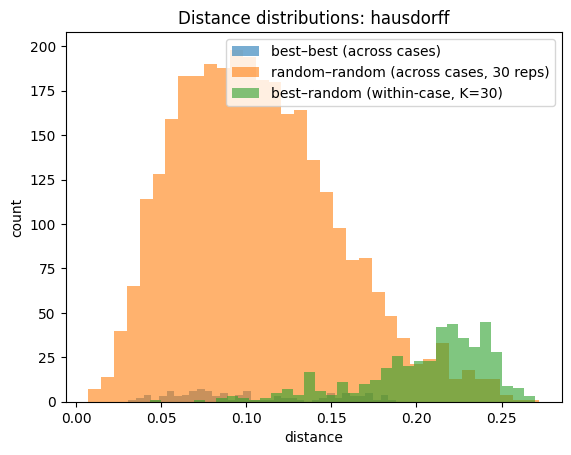

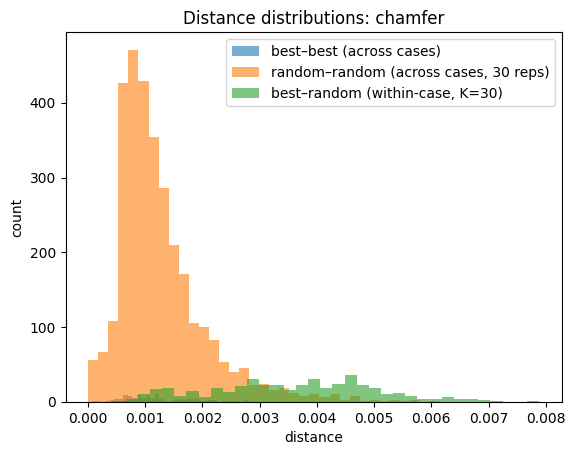

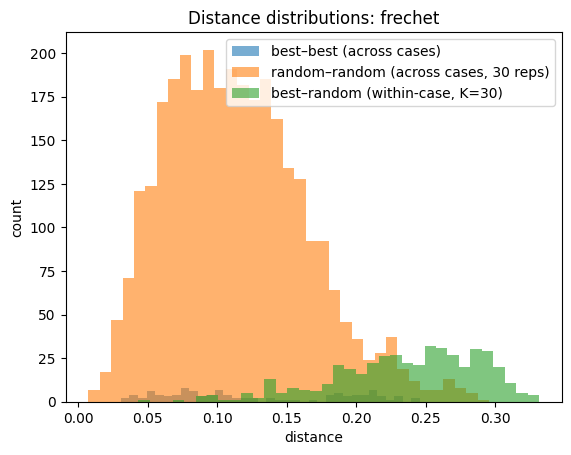

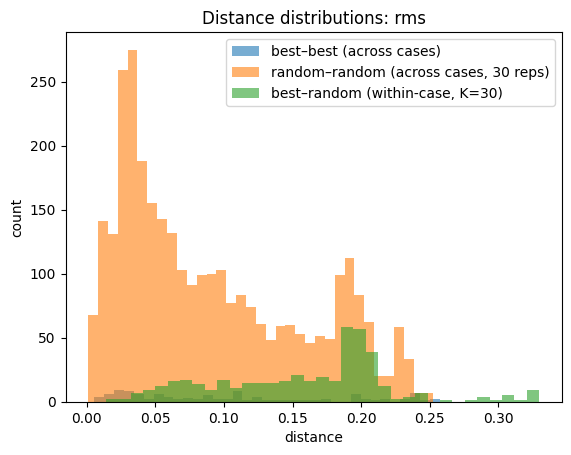

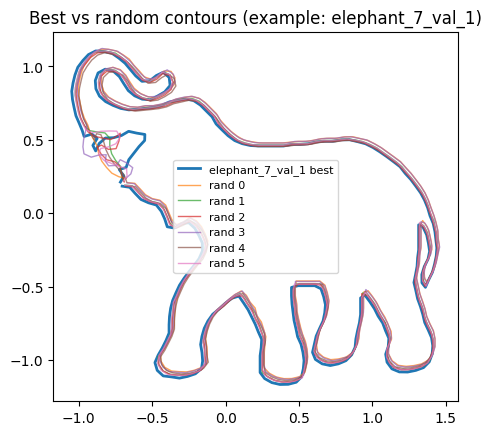

In [5]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Goal
# 1) For each case: best curve + K random curves from shapes_xy.npz (excluding best)
# 2) Compute 4 metrics:
#    - symmetric Hausdorff
#    - symmetric Chamfer
#    - discrete Fréchet
#    - Procrustes RMS (cyclic shift + optional rotation)
# 3) Compare distributions:
#    - best–best across cases
#    - random–random across cases (1 random per case, repeated R times)
#    - best–random within case
# 4) Report effect sizes (Cohen's d, Cliff's delta) + simple summaries
# ============================================================

# ----------------------------
# Settings
# ----------------------------
N_RESAMPLE = 256

RANDOM_PER_CASE = 30       # K random completions per case (within-case best–random uses these)
RR_REPEATS = 30            # how many random–random replicates (1 random per case per replicate)

SEED = 123
ROTATION_INVARIANT = True
ALLOW_REFLECTION = False
CYCLIC_SHIFTS = 32

CASES_ROOT = "/home/hschatzle/monte-carlo-selection/data/cases"
EPS = 1e-12

# Assumes you already have from previous steps:
#   selected = [(case_id, best_png, timestamp_utc), ...]
#   xy_by_case = {case_id: xy_best, ...}  # confirmed working
case_ids = [cid for cid, _, _ in selected if cid in xy_by_case]
best_png_by_case = {cid: best_png for cid, best_png, _ in selected if cid in xy_by_case}

print("Cases in analysis:", len(case_ids))

# ----------------------------
# Helpers: normalize + resample
# ----------------------------
def center_and_scale(xy: np.ndarray) -> np.ndarray:
    xy = np.asarray(xy, float)
    xy = xy - xy.mean(axis=0, keepdims=True)
    r = np.sqrt((xy**2).sum(axis=1)).mean()
    r = max(r, EPS)
    return xy / r

def resample_closed_curve_uniform_arclength(xy: np.ndarray, n: int) -> np.ndarray:
    xy = np.asarray(xy, float)
    if len(xy) < 3:
        raise ValueError("Contour too short")
    if not np.allclose(xy[0], xy[-1]):
        xy = np.vstack([xy, xy[0]])
    seg = np.diff(xy, axis=0)
    seglen = np.sqrt((seg**2).sum(axis=1))
    cum = np.concatenate([[0.0], np.cumsum(seglen)])
    total = cum[-1]
    if total < EPS:
        raise ValueError("Degenerate contour (zero perimeter)")
    t = np.linspace(0.0, total, n + 1)[:-1]
    x = np.interp(t, cum, xy[:, 0])
    y = np.interp(t, cum, xy[:, 1])
    return np.column_stack([x, y])

def prep_curve(xy: np.ndarray) -> np.ndarray:
    return resample_closed_curve_uniform_arclength(center_and_scale(xy), N_RESAMPLE)

# ----------------------------
# Metrics
# ----------------------------
def pairwise_sq_dists(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    D = A[:, None, :] - B[None, :, :]
    return (D * D).sum(axis=2)

def hausdorff_symmetric(A: np.ndarray, B: np.ndarray) -> float:
    D2 = pairwise_sq_dists(A, B)
    h_ab = np.sqrt(D2.min(axis=1).max())
    h_ba = np.sqrt(D2.min(axis=0).max())
    return float(max(h_ab, h_ba))

def chamfer_symmetric(A: np.ndarray, B: np.ndarray) -> float:
    D2 = pairwise_sq_dists(A, B)
    return float(D2.min(axis=1).mean() + D2.min(axis=0).mean())

def discrete_frechet(P: np.ndarray, Q: np.ndarray) -> float:
    n, m = len(P), len(Q)
    D = np.sqrt(pairwise_sq_dists(P, Q))
    ca = np.full((n, m), -1.0)

    def c(i, j):
        if ca[i, j] > -0.5:
            return ca[i, j]
        if i == 0 and j == 0:
            ca[i, j] = D[0, 0]
        elif i > 0 and j == 0:
            ca[i, j] = max(c(i - 1, 0), D[i, 0])
        elif i == 0 and j > 0:
            ca[i, j] = max(c(0, j - 1), D[0, j])
        else:
            ca[i, j] = max(min(c(i - 1, j), c(i - 1, j - 1), c(i, j - 1)), D[i, j])
        return ca[i, j]

    return float(c(n - 1, m - 1))

def procrustes_rms(A: np.ndarray, B: np.ndarray, rotation: bool, reflect: bool) -> float:
    A0 = A - A.mean(axis=0, keepdims=True)
    B0 = B - B.mean(axis=0, keepdims=True)

    if not rotation:
        diff = A0 - B0
        return float(np.sqrt((diff * diff).sum(axis=1).mean()))

    M = B0.T @ A0
    U, _, Vt = np.linalg.svd(M)
    R = U @ Vt
    if not reflect and np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    B_aligned = B0 @ R
    diff = A0 - B_aligned
    return float(np.sqrt((diff * diff).sum(axis=1).mean()))

def cyclic_shifted_rms(A: np.ndarray, B: np.ndarray, n_shifts: int, rotation: bool, reflect: bool) -> float:
    n = len(B)
    if n_shifts <= 1:
        return procrustes_rms(A, B, rotation=rotation, reflect=reflect)
    shifts = np.linspace(0, n - 1, n_shifts, dtype=int)
    best = np.inf
    for s in shifts:
        d = procrustes_rms(A, np.roll(B, shift=s, axis=0), rotation=rotation, reflect=reflect)
        if d < best:
            best = d
    return float(best)

def metric_bundle(A, B):
    return {
        "hausdorff": hausdorff_symmetric(A, B),
        "chamfer": chamfer_symmetric(A, B),
        "frechet": discrete_frechet(A, B),
        "rms": cyclic_shifted_rms(A, B, n_shifts=CYCLIC_SHIFTS, rotation=ROTATION_INVARIANT, reflect=ALLOW_REFLECTION),
    }

# ----------------------------
# Join best_png -> polygon index in shapes_xy.npz (exclude best when sampling random)
# ----------------------------
def find_best_polygon_index(case_id: str, best_png: str) -> int:
    npz_path = os.path.join(CASES_ROOT, case_id, "generated", "shapes_xy.npz")
    data = np.load(npz_path, allow_pickle=True)
    out_files = np.array([str(x) for x in data["out_files"]], dtype=object)
    polygons = data["polygons"]
    matlab_1_indexed = bool(data["matlab_1_indexed"])

    best_base = os.path.basename(best_png)

    matches = [i for i, s in enumerate(out_files) if os.path.basename(s) == best_base]
    if not matches:
        matches = [i for i, s in enumerate(out_files) if best_base in s]
    if not matches:
        m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
        if m:
            shape_id_str = m.group(2)
            shape_id_int = int(shape_id_str)
            matches = [i for i, s in enumerate(out_files) if (shape_id_str in s) or (str(shape_id_int) in s)]
    if matches:
        return matches[0]

    m = re.search(r"completion_(\d+)_(\d+)\.png$", best_base)
    if m:
        shape_id_int = int(m.group(2))
        idx = shape_id_int - 1 if matlab_1_indexed else shape_id_int
        if 0 <= idx < len(polygons):
            return idx

    raise RuntimeError(f"Could not locate best index for case_id={case_id}")

# ----------------------------
# Load all best curves + sample random curves
# ----------------------------
rng = np.random.default_rng(SEED)

best_curves = {}
random_curves = {}  # (case_id, r_i) -> curve

best_idx_by_case = {}

failures = []
for cid in case_ids:
    try:
        best_idx_by_case[cid] = find_best_polygon_index(cid, best_png_by_case[cid])
        best_curves[cid] = prep_curve(xy_by_case[cid])

        npz_path = os.path.join(CASES_ROOT, cid, "generated", "shapes_xy.npz")
        data = np.load(npz_path, allow_pickle=True)
        polygons = data["polygons"]
        n_total = len(polygons)

        candidates = np.arange(n_total)
        candidates = candidates[candidates != best_idx_by_case[cid]]

        replace = RANDOM_PER_CASE > len(candidates)
        picks = rng.choice(candidates, size=RANDOM_PER_CASE, replace=replace)

        for r_i, idx in enumerate(picks):
            random_curves[(cid, r_i)] = prep_curve(np.asarray(polygons[idx], float))
    except Exception as e:
        failures.append((cid, str(e)))

print("Loaded best curves:", len(best_curves))
print("Loaded random curves:", len(random_curves))
print("Failures:", len(failures))
if failures:
    print("First failures:", failures[:5])

# keep only successful cases
case_ids_ok = [cid for cid in case_ids if cid in best_curves]
print("Cases retained:", len(case_ids_ok))

# ----------------------------
# Build comparison sets
# ----------------------------
def upper_triangle_pairs(ids):
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            yield ids[i], ids[j]

# 1) best–best (across cases)
best_best = {k: [] for k in ["hausdorff", "chamfer", "frechet", "rms"]}
for a, b in upper_triangle_pairs(case_ids_ok):
    m = metric_bundle(best_curves[a], best_curves[b])
    for k, v in m.items():
        best_best[k].append(v)

# 2) best–random (within-case)
best_rand = {k: [] for k in ["hausdorff", "chamfer", "frechet", "rms"]}
for cid in case_ids_ok:
    A = best_curves[cid]
    for r_i in range(RANDOM_PER_CASE):
        B = random_curves[(cid, r_i)]
        m = metric_bundle(A, B)
        for k, v in m.items():
            best_rand[k].append(v)

# 3) random–random (across cases), matched size, repeated RR_REPEATS times:
#    For each replicate, choose one random completion per case (same r_i across cases),
#    or choose a fresh random index per case. We do fresh sampling per replicate.
rand_rand = {k: [] for k in ["hausdorff", "chamfer", "frechet", "rms"]}

for rep in range(RR_REPEATS):
    # pick one of the stored random curves per case, independently
    one = {}
    for cid in case_ids_ok:
        r_i = int(rng.integers(0, RANDOM_PER_CASE))
        one[cid] = random_curves[(cid, r_i)]
    for a, b in upper_triangle_pairs(case_ids_ok):
        m = metric_bundle(one[a], one[b])
        for k, v in m.items():
            rand_rand[k].append(v)

# ----------------------------
# Effect sizes
# ----------------------------
def cohen_d(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    vx = x.var(ddof=1)
    vy = y.var(ddof=1)
    sp = np.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    if sp < EPS:
        return np.nan
    return float((x.mean() - y.mean()) / sp)

def cliffs_delta(x, y):
    # O(n*m) but sizes here are fine
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    gt = 0
    lt = 0
    for xi in x:
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    denom = len(x) * len(y)
    if denom == 0:
        return np.nan
    return float((gt - lt) / denom)

def summary_stats(arr):
    arr = np.asarray(arr, float)
    return dict(
        n=int(len(arr)),
        mean=float(arr.mean()) if len(arr) else np.nan,
        median=float(np.median(arr)) if len(arr) else np.nan,
        std=float(arr.std(ddof=1)) if len(arr) > 1 else np.nan,
        q10=float(np.quantile(arr, 0.10)) if len(arr) else np.nan,
        q90=float(np.quantile(arr, 0.90)) if len(arr) else np.nan,
    )

# We want: best-best smaller than rand-rand (i.e., "more similar").
# For d: (best-best - rand-rand) negative indicates best-best is smaller.
print("\n=== Summaries + effect sizes (best-best vs rand-rand) ===")
for k in ["hausdorff", "chamfer", "frechet", "rms"]:
    bb = best_best[k]
    rr = rand_rand[k]
    stats_bb = summary_stats(bb)
    stats_rr = summary_stats(rr)

    d = cohen_d(bb, rr)
    cd = cliffs_delta(bb, rr)

    print(f"\nMetric: {k}")
    print("  best-best:", stats_bb)
    print("  rand-rand:", stats_rr)
    print(f"  Cohen's d (bb - rr): {d:.3f}  (negative => best-best smaller)")
    print(f"  Cliff's delta (bb vs rr): {cd:.3f}  (negative => bb tends smaller)")

print("\n=== Summaries + effect sizes (best-rand within-case vs rand-rand across-case) ===")
for k in ["hausdorff", "chamfer", "frechet", "rms"]:
    br = best_rand[k]
    rr = rand_rand[k]
    d = cohen_d(br, rr)
    cd = cliffs_delta(br, rr)
    print(f"\nMetric: {k}")
    print("  best-rand:", summary_stats(br))
    print("  rand-rand:", summary_stats(rr))
    print(f"  Cohen's d (br - rr): {d:.3f}")
    print(f"  Cliff's delta (br vs rr): {cd:.3f}")

# ----------------------------
# Plots: distribution comparison for each metric
# ----------------------------
def plot_hist(metric_key, bins=35):
    bb = np.asarray(best_best[metric_key], float)
    rr = np.asarray(rand_rand[metric_key], float)
    br = np.asarray(best_rand[metric_key], float)

    plt.figure()
    plt.hist(bb, bins=bins, alpha=0.6, label="best–best (across cases)")
    plt.hist(rr, bins=bins, alpha=0.6, label=f"random–random (across cases, {RR_REPEATS} reps)")
    plt.hist(br, bins=bins, alpha=0.6, label=f"best–random (within-case, K={RANDOM_PER_CASE})")
    plt.title(f"Distance distributions: {metric_key}")
    plt.xlabel("distance")
    plt.ylabel("count")
    plt.legend()
    plt.show()

for k in ["hausdorff", "chamfer", "frechet", "rms"]:
    plot_hist(k)

# ----------------------------
# Diagnostic overlay: pick one case and show best + a few randoms
# ----------------------------
example_cid = case_ids_ok[0] if case_ids_ok else None
if example_cid is not None:
    plt.figure()
    plt.plot(best_curves[example_cid][:, 0], best_curves[example_cid][:, 1], linewidth=2, label=f"{example_cid} best")
    for r_i in range(min(6, RANDOM_PER_CASE)):
        B = random_curves[(example_cid, r_i)]
        plt.plot(B[:, 0], B[:, 1], linewidth=1, alpha=0.7, label=f"rand {r_i}")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Best vs random contours (example: {example_cid})")
    plt.legend(fontsize=8)
    plt.show()


Best–best n: 105  mean: 0.001188166922962089
Best–random n: 450  mean: 0.003563941565776015


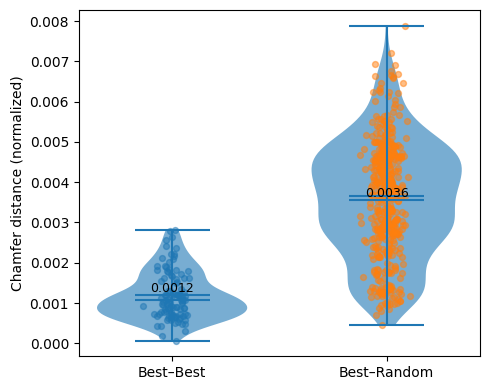

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Chamfer distances
bb = np.asarray(best_best["chamfer"], float)   # best–best
br = np.asarray(best_rand["chamfer"], float)   # best–random

print("Best–best n:", len(bb), " mean:", bb.mean())
print("Best–random n:", len(br), " mean:", br.mean())

# ----------------------------
# Build data for plotting
# ----------------------------
data = [bb, br]
labels = ["Best–Best", "Best–Random"]

# ----------------------------
# Violin + jitter plot
# ----------------------------
plt.figure(figsize=(5, 4))

vp = plt.violinplot(
    data,
    showmeans=True,
    showmedians=True,
    widths=0.7
)

# Style violins
for body in vp['bodies']:
    body.set_alpha(0.6)

# Jittered scatter (to show samples)
for i, d in enumerate(data, start=1):
    x = np.random.normal(i, 0.04, size=len(d))
    plt.scatter(x, d, s=18, alpha=0.5)

plt.xticks([1, 2], labels)
plt.ylabel("Chamfer distance (normalized)")


# Optional: annotate means
plt.text(1, bb.mean(), f"{bb.mean():.4f}", ha="center", va="bottom", fontsize=9)
plt.text(2, br.mean(), f"{br.mean():.4f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()



In [17]:
ratio = br.mean() / bb.mean()
print("Similarity improvement ratio (best-random / best-best):", ratio)


Similarity improvement ratio (best-random / best-best): 3.049298814837043


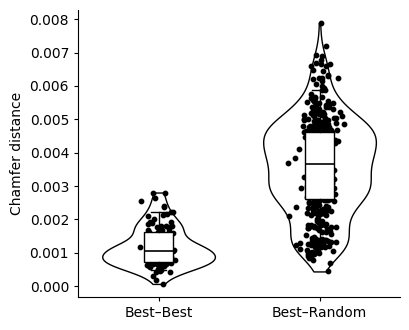

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Data
# ----------------------------
bb = np.asarray(best_best["chamfer"], float)
br = np.asarray(best_rand["chamfer"], float)

data = [bb, br]
labels = ["Best–Best", "Best–Random"]
xpos = [1, 2]

# ----------------------------
# Figure
# ----------------------------
fig, ax = plt.subplots(figsize=(4.2, 3.4))

# --- Violin (distribution shape only) ---
vp = ax.violinplot(
    data,
    positions=xpos,
    widths=0.7,
    showmeans=False,
    showmedians=False,
    showextrema=False
)

for body in vp["bodies"]:
    body.set_facecolor("white")
    body.set_edgecolor("black")
    body.set_linewidth(1.0)
    body.set_alpha(1.0)

# --- Boxplot overlay (structure only) ---
bp = ax.boxplot(
    data,
    positions=xpos,
    widths=0.18,
    patch_artist=True,
    showfliers=False,
    whis=(5, 95),
    boxprops=dict(facecolor="white", edgecolor="black", linewidth=1.0),
    medianprops=dict(color="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1.0),
    capprops=dict(color="black", linewidth=1.0),
)

# --- Raw data points (no color) ---
rng = np.random.default_rng(0)
for i, d in enumerate(data, start=1):
    x = rng.normal(i, 0.05, size=len(d))
    ax.scatter(x, d, s=10, color="black", alpha=1.0)

# ----------------------------
# Axes styling (minimal)
# ----------------------------
ax.set_xticks(xpos)
ax.set_xticklabels(labels)
ax.set_ylabel("Chamfer distance")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='both', which='both', length=3)

fig.tight_layout()

# ----------------------------
# Export for Illustrator
# ----------------------------
plt.savefig("panel_d_violin.svg")
plt.savefig("panel_d_violin.pdf")
plt.show()
